In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!ls "/content/drive/MyDrive/My First Project.v15i.yolov11"

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [13]:
!pip install ultralytics torch torchvision opencv-python matplotlib

In [14]:
!pip install ultralytics

In [15]:
from ultralytics import YOLO

In [16]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
from PIL import Image
import numpy as np

In [17]:
DATASET_PATH = "/content/drive/MyDrive/My First Project.v15i.yolov11"  # Change to your dataset path
IMG_SIZE = 416  # Image size for training

import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Example Vision Transformer

# Load YOLOv10m model
model = YOLO("yolo12s.pt")




100%|██████████| 18.1M/18.1M [00:00<00:00, 201MB/s]


In [18]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Small Vision Transformer

class HybridBackbone(nn.Module):
    def __init__(self, yolo_backbone, transformer):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.transformer = transformer

    def forward(self, x):
        # Extract features using YOLO's CNN backbone
        cnn_features = self.yolo_backbone(x)

        # Transformer expects a different input shape, so adjust it
        b, c, h, w = cnn_features.shape
        cnn_features = cnn_features.view(b, c, -1).permute(2, 0, 1)  # Reshape for transformer input

        # Extract transformer features
        transformer_features = self.transformer(cnn_features)

        # Reshape back to CNN format
        transformer_features = transformer_features.permute(1, 2, 0).view(b, c, h, w)

        return transformer_features

# Extract YOLO's original backbone
yolo_backbone = model.model.model[0]  # This extracts YOLO's backbone

# Load a pretrained Vision Transformer
transformer = vit_b_16(pretrained=True)
transformer.heads = nn.Identity()  # Remove classification head

# Create a new hybrid backbone
hybrid_backbone = HybridBackbone(yolo_backbone, transformer)

# Replace YOLO's backbone with the hybrid version
model.model.model[0] = hybrid_backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 90.7MB/s]


In [19]:
model.train(
    epochs=50,
    batch=16,
    imgsz=416,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=6,  # Early stopping with patience 6

    data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml",
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml, epochs=50, time=None, patience=6, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.1MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels... 2436 images, 420 backgrounds, 0 corrupt: 100%|██████████| 2436/2436 [14:10<00:00,  2.86it/s]


train: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [01:29<00:00,  2.96it/s]

val: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.42G          2      3.694      2.014         19        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.90it/s]

                   all        266        295      0.289     0.0737     0.0161    0.00585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.79G      2.058      3.206      2.039          6        416: 100%|██████████| 153/153 [00:46<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


                   all        266        295      0.369      0.134      0.085     0.0304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.81G       2.08       3.23      2.031          2        416: 100%|██████████| 153/153 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]


                   all        266        295     0.0389     0.0828     0.0197    0.00622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.87G      2.041      3.108      2.008          9        416: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

                   all        266        295      0.177      0.105     0.0673     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.91G      1.971      3.023      1.932          4        416: 100%|██████████| 153/153 [00:46<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


                   all        266        295      0.189      0.258      0.115     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.95G      1.914      2.924      1.876          5        416: 100%|██████████| 153/153 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        266        295      0.207      0.197      0.147     0.0645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.96G      1.887      2.804      1.849          8        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        266        295      0.279      0.253      0.234      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.03G      1.844      2.752      1.825          7        416: 100%|██████████| 153/153 [00:45<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


                   all        266        295      0.257      0.241      0.185     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.06G       1.82      2.697      1.809          5        416: 100%|██████████| 153/153 [00:45<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.56it/s]

                   all        266        295      0.287       0.24      0.215        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.22G      1.816      2.681      1.793          9        416: 100%|██████████| 153/153 [00:46<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

                   all        266        295      0.448      0.257      0.291      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.24G      1.741      2.582      1.772          8        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        266        295      0.483      0.279      0.246      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.3G      1.751      2.597      1.756          7        416: 100%|██████████| 153/153 [00:46<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


                   all        266        295       0.61      0.279      0.318      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.34G       1.76      2.554      1.765         10        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


                   all        266        295      0.345      0.259      0.277      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.38G      1.711      2.473      1.741          8        416: 100%|██████████| 153/153 [00:45<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


                   all        266        295      0.469       0.29      0.321      0.159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.4G      1.689      2.446      1.705          8        416: 100%|██████████| 153/153 [00:45<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all        266        295      0.337       0.39      0.333      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.46G      1.707      2.406      1.707          9        416: 100%|██████████| 153/153 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]


                   all        266        295      0.313      0.387       0.34      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.49G      1.667      2.375      1.698          8        416: 100%|██████████| 153/153 [00:46<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        266        295      0.383      0.389      0.345      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.54G      1.677      2.374      1.687         17        416: 100%|██████████| 153/153 [00:44<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


                   all        266        295      0.477      0.316      0.368      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.55G      1.668      2.339      1.684          6        416: 100%|██████████| 153/153 [00:46<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


                   all        266        295      0.446      0.373      0.351      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.61G      1.633      2.305      1.687          7        416: 100%|██████████| 153/153 [00:45<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


                   all        266        295      0.315      0.469      0.352      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.65G      1.623      2.262      1.656          4        416: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        266        295       0.44      0.421      0.401      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.69G      1.617      2.238      1.662          3        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

                   all        266        295      0.404      0.448      0.388      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.71G       1.63      2.238      1.658          6        416: 100%|██████████| 153/153 [00:45<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

                   all        266        295      0.488       0.37      0.383      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.77G      1.591      2.209      1.652          3        416: 100%|██████████| 153/153 [00:46<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.38it/s]


                   all        266        295      0.436      0.425      0.413      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.81G      1.581      2.164      1.645          8        416: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


                   all        266        295       0.47      0.376      0.378        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.85G      1.563      2.123      1.622          7        416: 100%|██████████| 153/153 [00:46<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


                   all        266        295      0.441      0.451      0.439      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.86G       1.55      2.107      1.628          9        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        266        295      0.512      0.438      0.426       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.92G      1.541      2.059      1.598          7        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


                   all        266        295      0.538      0.477      0.442      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.11G      1.552      2.029      1.604          8        416: 100%|██████████| 153/153 [00:46<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

                   all        266        295      0.579      0.408      0.456      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.14G      1.535      2.026      1.601         12        416: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        266        295      0.549      0.441      0.471      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.16G      1.528      2.017       1.59          6        416: 100%|██████████| 153/153 [00:46<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

                   all        266        295       0.49       0.47      0.454      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.22G      1.516      1.971      1.596         17        416: 100%|██████████| 153/153 [00:45<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        266        295      0.452      0.535      0.495      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.26G      1.502      1.972      1.578          9        416: 100%|██████████| 153/153 [00:46<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        266        295      0.506      0.472      0.481      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       4.3G      1.501      1.945      1.588         15        416: 100%|██████████| 153/153 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

                   all        266        295      0.583      0.403       0.46      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.32G       1.47      1.904      1.557          5        416: 100%|██████████| 153/153 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

                   all        266        295      0.543      0.483      0.486      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.38G      1.472      1.879      1.566         12        416: 100%|██████████| 153/153 [00:47<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


                   all        266        295      0.498      0.465      0.463      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.42G      1.484      1.847      1.573          6        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all        266        295       0.53      0.502      0.494      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.46G      1.446      1.816      1.548          4        416: 100%|██████████| 153/153 [00:44<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]

                   all        266        295      0.577       0.49      0.488      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.47G      1.437       1.78      1.535          7        416: 100%|██████████| 153/153 [00:45<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


                   all        266        295      0.571      0.471      0.487      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.53G      1.422      1.804      1.528          6        416: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


                   all        266        295      0.613      0.452      0.531      0.293
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.57G      1.429      1.623      1.553          4        416: 100%|██████████| 153/153 [00:47<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        266        295      0.557      0.534      0.526      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.61G      1.416       1.58      1.557          3        416: 100%|██████████| 153/153 [00:44<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

                   all        266        295      0.629      0.519      0.546      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.63G      1.393      1.501      1.533          6        416: 100%|██████████| 153/153 [00:44<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

                   all        266        295      0.668        0.5      0.562      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       4.7G      1.376      1.433      1.516          6        416: 100%|██████████| 153/153 [00:44<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]

                   all        266        295      0.653      0.527      0.575      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.76G      1.364      1.399      1.511         10        416: 100%|██████████| 153/153 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


                   all        266        295      0.594      0.563      0.565      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.94G      1.362      1.388      1.508          5        416: 100%|██████████| 153/153 [00:44<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


                   all        266        295      0.609      0.538      0.564      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.96G      1.348      1.362      1.499          9        416: 100%|██████████| 153/153 [00:45<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


                   all        266        295      0.581      0.576      0.559       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.02G      1.336      1.331      1.481          6        416: 100%|██████████| 153/153 [00:44<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.59it/s]

                   all        266        295      0.659      0.521      0.579      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.05G      1.306      1.304      1.467          4        416: 100%|██████████| 153/153 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        266        295      0.635      0.533      0.567      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.09G      1.302      1.273      1.468          5        416: 100%|██████████| 153/153 [00:44<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.18it/s]


                   all        266        295       0.61      0.562      0.583      0.324

50 epochs completed in 0.690 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


                   all        266        295       0.61      0.562      0.582      0.325
                 cloth         49         68      0.626      0.574      0.642      0.387
                 glass         60         60      0.675      0.692      0.694      0.367
                 metal         45         55      0.574      0.491      0.484      0.252
               plastic         80        112      0.566      0.491       0.51      0.292
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79a8d0667a90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [20]:
metrics = model.val()  # Validate the model

# Extract values correctly
precision = metrics.box.p.mean()  # Mean Precision
recall = metrics.box.r.mean()  # Mean Recall
map50 = metrics.box.map50  # Mean Average Precision @ 50
map50_95 = metrics.box.map  # Mean Average Precision @ 50-95

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


                   all        266        295       0.61      0.562      0.583      0.325
                 cloth         49         68      0.623      0.574      0.643      0.388
                 glass         60         60      0.675      0.693      0.694      0.367
                 metal         45         55      0.572      0.491      0.484      0.253
               plastic         80        112      0.568      0.491      0.509      0.293
Speed: 0.8ms preprocess, 7.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train2
Precision: 0.6099, Recall: 0.5622, mAP@50: 0.5827, mAP@50-95: 0.3252



0: 416x416 1 cloth, 12.7ms
Speed: 1.9ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


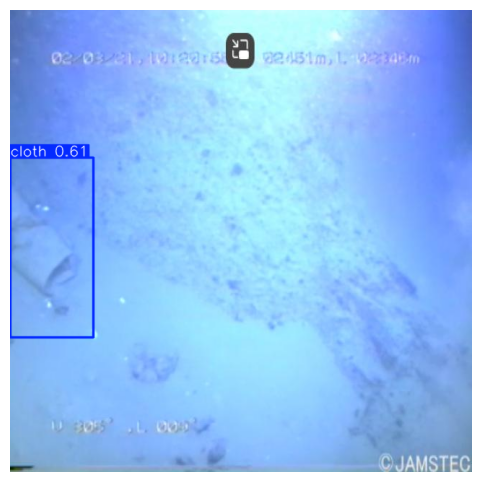

In [21]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

def visualize_results(img_path, model):
    img = Image.open(img_path)
    results = model(img)

    # Extract the first result and get the plotted image
    result_img = results[0].plot()

    # Convert image to NumPy array if it's not already
    result_img = np.array(result_img)

    # Convert BGR (OpenCV default) to RGB for correct display in matplotlib
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Show image with bounding boxes
    plt.figure(figsize=(6,6))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()
    plt.pause(0.001)  # Force display update
    plt.close()  # Prevent duplicate figures

# Load test images
test_images = glob.glob("/content/drive/MyDrive/My First Project.v15i.yolov11/test/images/*.jpg")

# Run visualization
if test_images:
    visualize_results(test_images[200], model)
else:
    print("No test images found.")

In [22]:
import glob
model_files = glob.glob("/content/runs/detect/*/weights/best.pt")
print("Available model files:", model_files)

Available model files: ['/content/runs/detect/train/weights/best.pt']


In [23]:
import glob

# List all training runs
train_folders = glob.glob("/content/runs/detect/*/")

print("Available training runs:")
for folder in train_folders:
    print(folder)

Available training runs:
/content/runs/detect/train/
/content/runs/detect/train2/


In [24]:
import glob

# Check logs inside different training folders
for folder in train_folders:
    log_files = glob.glob(folder + "/*.csv")
    if log_files:
        print(f"✅ Logs found in: {folder}")
        print(log_files)
    else:
        print(f"❌ No CSV logs found in: {folder}")

✅ Logs found in: /content/runs/detect/train/
['/content/runs/detect/train/results.csv']
❌ No CSV logs found in: /content/runs/detect/train2/


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


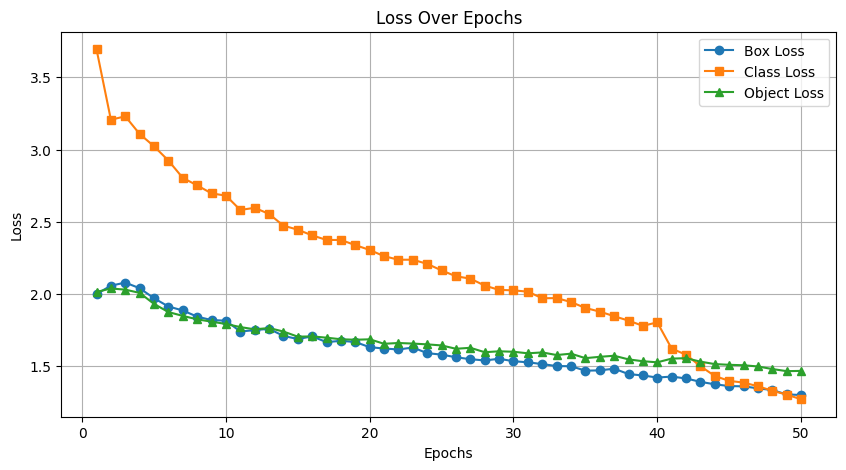

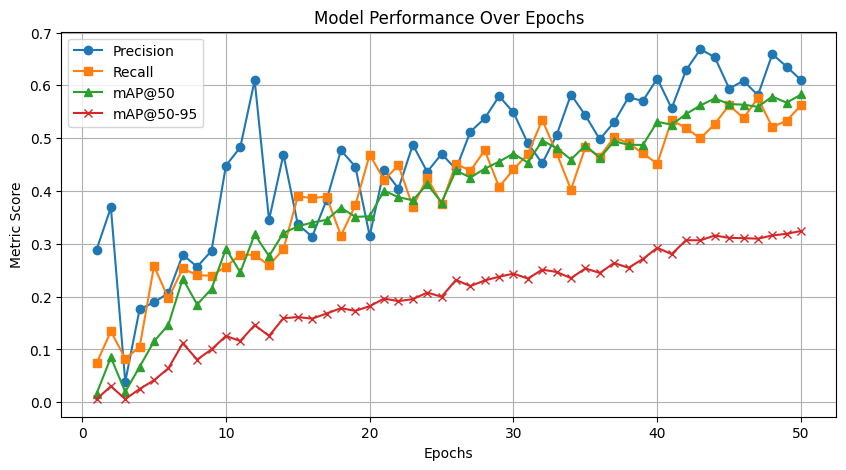

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the CSV file
csv_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

# Print column names to check available metrics
print("Available columns:", df.columns)

# ✅ Force Matplotlib to display the figures
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss", marker='s')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Object Loss", marker='^')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='s')
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='^')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Model Performance Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

# ✅ Call the functions
plot_loss()
plot_accuracy()


In [26]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Evaluate on the test dataset
metrics = model.val(data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml", split="test")

# Extract performance metrics
print("mAP50:", metrics.box.map50)      # Mean Average Precision at IoU 0.5
print("mAP50-95:", metrics.box.map)     # Mean Average Precision at IoU 0.5:0.95
print("Precision:", metrics.box.p.mean())   # Mean Precision across all classes
print("Recall:", metrics.box.r.mean())  # Mean Recall across all classes
print("F1 Score:", metrics.box.f1.mean())  # Mean F1 Score

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [01:28<00:00,  2.99it/s]

val: New cache created: /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]


                   all        266        321      0.682      0.504      0.574      0.313
                 cloth         46         70       0.66      0.526       0.55      0.356
                 glass         59         59       0.85       0.78      0.851       0.47
                 metal         45         56      0.602      0.321      0.404      0.183
               plastic         82        136      0.617       0.39      0.491      0.242
Speed: 1.2ms preprocess, 6.1ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.5740474970022436
mAP50-95: 0.3129028937517017
Precision: 0.6823739327285047
Recall: 0.5042447115034286
F1 Score: 0.5739439727708008


In [27]:
import shutil

# Define source and destination paths
source_path = "/content/runs/detect/train/weights/best.pt"
destination_path = "/content/yolov12s.pt"

# Ensure the destination folder exists
shutil.os.makedirs("/content/drive/My Drive/saved_models", exist_ok=True)

# Copy the trained model to Google Drive
shutil.copy(source_path, destination_path)

print(f"✅ Model successfully saved to: {destination_path}")

✅ Model successfully saved to: /content/yolov12s.pt
